# 1. 강의영상 

# 2. ref 

ref: <https://huggingface.co/docs/transformers/tasks/image_classification>

# 3. imports 

In [2]:
import datasets
import transformers
import torchvision.transforms
import evaluate
import numpy as np

/home/cgb3/anaconda3/envs/hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 4. 코드정리1

In [442]:
## Step1 
food = datasets.load_dataset("food101", split="train[:5000]")
food = food.train_test_split(test_size=0.2)
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
normalize = torchvision.transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size), 
    torchvision.transforms.ToTensor(), 
    normalize
])
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food = food.with_transform(transforms)
## Step2 
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)
## Step3 
data_collator = transformers.DefaultDataCollator()
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)
training_args = transformers.TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)
trainer.train()
## Step4 

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
0,2.680100,2.553088,0.804000
2,1.590500,1.642717,0.867000


TrainOutput(global_step=186, training_loss=2.439177390067808, metrics={'train_runtime': 142.1266, 'train_samples_per_second': 84.432, 'train_steps_per_second': 1.309, 'total_flos': 9.232831524962304e+17, 'train_loss': 2.439177390067808, 'epoch': 2.976})

In [443]:
# Step4 
ds = datasets.load_dataset("food101", split="validation[:10]")
image = ds["image"][0]
classifier = transformers.pipeline("image-classification", model="my_awesome_food_model/checkpoint-186")
classifier(image)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'beignets', 'score': 0.9671740531921387},
 {'label': 'bruschetta', 'score': 0.6163783073425293},
 {'label': 'prime_rib', 'score': 0.6034657955169678},
 {'label': 'chicken_wings', 'score': 0.599809467792511},
 {'label': 'pork_chop', 'score': 0.5689510703086853}]

# 5. 살펴보기 

## A. 데이터불러오기 

`-` 원래는 자료가 많음 

In [323]:
food_full = datasets.load_dataset("food101")
food_full

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

`-` train에서 5000장만 가져옴 

In [324]:
food5000 = datasets.load_dataset("food101", split="train[:5000]")
food5000

Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

`-` 거기서 8:2로 데이터를 분리 

In [325]:
food = food5000.train_test_split(test_size=0.2)
food

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

## B. 데이터 살펴보기 

`-` 이미지를 보는 방법 

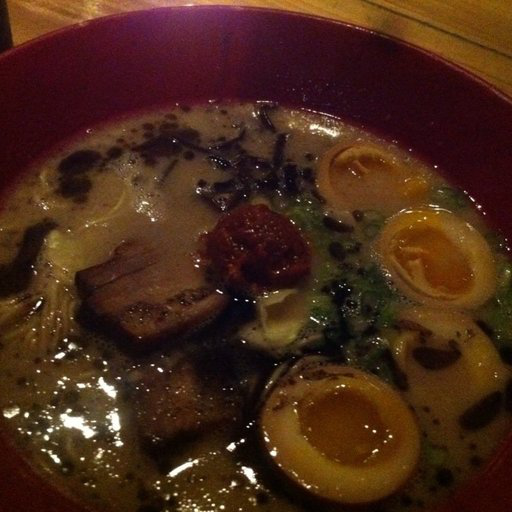

In [118]:
food['train'][0]['image']

`-` 이미지에 해당하는 라벨을 같이 확인하는 방법 

81


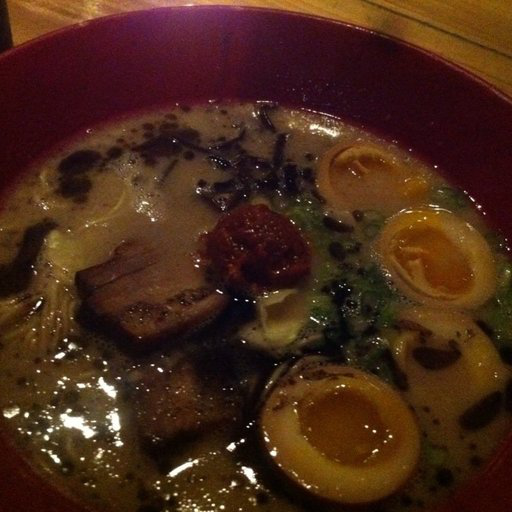

In [119]:
print(food['train'][0]['label'])
food['train'][0]['image']

53번이 뭐지?

In [120]:
food['train'].features['label'].names[53]

'hamburger'

`-` 이미지의 크기를 확인하는 방법 

In [121]:
sizes = [dct['image'].__str__().split(" ")[-3] for dct in food['train']]
sizes[:5]

['size=512x512',
 'size=512x512',
 'size=512x512',
 'size=512x512',
 'size=512x384']

In [122]:
sizes = [dct['image'].size for dct in food['train']]
sizes[:5]

[(512, 512), (512, 512), (512, 512), (512, 512), (512, 384)]

- 이미지의 크기가 서로 다르네? (텍스트의 길이가 다르듯이?)
- 인공지능입장에선 싫어하겠는걸

## C. `torchvision.transforms` 소개 

`-` 이미지자료 하나 받아두기 

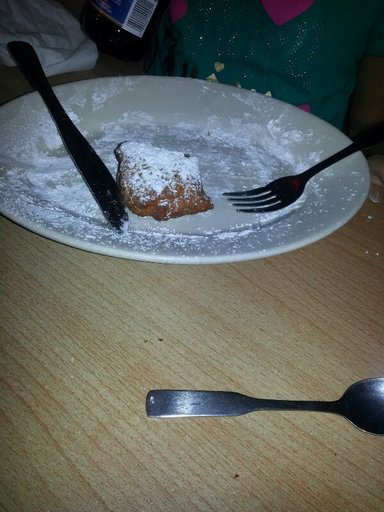

In [161]:
img = datasets.load_dataset("food101",split="train[:1]")[0]['image']
img

#### `# torchvision.transforms.RandomResizedCrop`

`# 예시1` -- 사이즈를 224,112로 조정 

In [207]:
자르고크기조정하기 = torchvision.transforms.RandomResizedCrop((224,112))

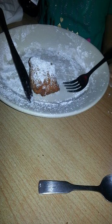

In [208]:
자르고크기조정하기(img) # 5번정도 실행해보기..

`#` 

`# 예시2` -- 사이즈를 224,224로 조정 

In [209]:
자르고크기조정하기 = torchvision.transforms.RandomResizedCrop(224)

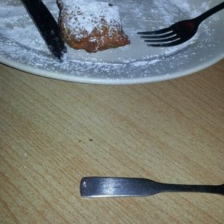

In [210]:
자르고크기조정하기(img) # 5번정도 실행해보기..

`#` 

#### `# torchvision.transforms.ToTensor()` 

`# 예시1` 

In [216]:
텐서화하기 = torchvision.transforms.ToTensor()

In [217]:
텐서화하기(img)

tensor([[[0.1216, 0.1137, 0.1098,  ..., 0.0039, 0.0039, 0.0000],
         [0.1255, 0.1216, 0.1176,  ..., 0.0039, 0.0039, 0.0000],
         [0.1294, 0.1255, 0.1255,  ..., 0.0039, 0.0000, 0.0000],
         ...,
         [0.2588, 0.2745, 0.2863,  ..., 0.3765, 0.3882, 0.3922],
         [0.2353, 0.2471, 0.2667,  ..., 0.3373, 0.3373, 0.3373],
         [0.2235, 0.2275, 0.2471,  ..., 0.3333, 0.3176, 0.3059]],

        [[0.1373, 0.1294, 0.1255,  ..., 0.1020, 0.1020, 0.0980],
         [0.1412, 0.1373, 0.1333,  ..., 0.1020, 0.1020, 0.0980],
         [0.1451, 0.1412, 0.1412,  ..., 0.1020, 0.0980, 0.0980],
         ...,
         [0.2471, 0.2627, 0.2745,  ..., 0.3647, 0.3765, 0.3882],
         [0.2235, 0.2353, 0.2549,  ..., 0.3255, 0.3333, 0.3333],
         [0.2118, 0.2157, 0.2353,  ..., 0.3216, 0.3137, 0.3020]],

        [[0.1412, 0.1333, 0.1294,  ..., 0.0902, 0.0902, 0.0863],
         [0.1451, 0.1412, 0.1451,  ..., 0.0902, 0.0902, 0.0863],
         [0.1490, 0.1451, 0.1529,  ..., 0.0902, 0.0863, 0.

In [218]:
텐서화하기(img).shape

torch.Size([3, 512, 384])

`#`

`# 예시2` -- `자르고크기조정하기` 와 `텐서화하기`를 동시에 사용하는 경우 

In [213]:
텐서화하기(자르고크기조정하기(img)).shape

torch.Size([3, 224, 224])

In [214]:
자르고크기조정하기(텐서화하기(img)).shape

torch.Size([3, 224, 224])

`#`

#### `# torchvision.transforms.Normalize`

`# 예시1`

In [258]:
표준화하기 = torchvision.transforms.Normalize(mean=[10,20,30], std=[0.5,1.0,1.5])

In [265]:
표준화하기(텐서화하기(img))[0], (텐서화하기(img)[0] - 10 ) / 0.5

(tensor([[-19.7569, -19.7725, -19.7804,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7490, -19.7569, -19.7647,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7412, -19.7490, -19.7490,  ..., -19.9922, -20.0000, -20.0000],
         ...,
         [-19.4824, -19.4510, -19.4275,  ..., -19.2471, -19.2235, -19.2157],
         [-19.5294, -19.5059, -19.4667,  ..., -19.3255, -19.3255, -19.3255],
         [-19.5529, -19.5451, -19.5059,  ..., -19.3333, -19.3647, -19.3882]]),
 tensor([[-19.7569, -19.7725, -19.7804,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7490, -19.7569, -19.7647,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7412, -19.7490, -19.7490,  ..., -19.9922, -20.0000, -20.0000],
         ...,
         [-19.4824, -19.4510, -19.4275,  ..., -19.2471, -19.2235, -19.2157],
         [-19.5294, -19.5059, -19.4667,  ..., -19.3255, -19.3255, -19.3255],
         [-19.5529, -19.5451, -19.5059,  ..., -19.3333, -19.3647, -19.3882]]))

In [266]:
표준화하기(텐서화하기(img))[1], (텐서화하기(img)[1] - 20 ) / 1.0

(tensor([[-19.8627, -19.8706, -19.8745,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8588, -19.8627, -19.8667,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8549, -19.8588, -19.8588,  ..., -19.8980, -19.9020, -19.9020],
         ...,
         [-19.7529, -19.7373, -19.7255,  ..., -19.6353, -19.6235, -19.6118],
         [-19.7765, -19.7647, -19.7451,  ..., -19.6745, -19.6667, -19.6667],
         [-19.7882, -19.7843, -19.7647,  ..., -19.6784, -19.6863, -19.6980]]),
 tensor([[-19.8627, -19.8706, -19.8745,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8588, -19.8627, -19.8667,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8549, -19.8588, -19.8588,  ..., -19.8980, -19.9020, -19.9020],
         ...,
         [-19.7529, -19.7373, -19.7255,  ..., -19.6353, -19.6235, -19.6118],
         [-19.7765, -19.7647, -19.7451,  ..., -19.6745, -19.6667, -19.6667],
         [-19.7882, -19.7843, -19.7647,  ..., -19.6784, -19.6863, -19.6980]]))

In [267]:
표준화하기(텐서화하기(img))[2], (텐서화하기(img)[2] - 30 ) / 1.5

(tensor([[-19.9059, -19.9111, -19.9137,  ..., -19.9399, -19.9399, -19.9425],
         [-19.9033, -19.9059, -19.9033,  ..., -19.9399, -19.9399, -19.9425],
         [-19.9007, -19.9033, -19.8980,  ..., -19.9399, -19.9425, -19.9425],
         ...,
         [-19.8850, -19.8745, -19.8667,  ..., -19.8379, -19.8301, -19.8222],
         [-19.9007, -19.8928, -19.8797,  ..., -19.8641, -19.8588, -19.8588],
         [-19.9085, -19.9059, -19.8928,  ..., -19.8667, -19.8719, -19.8797]]),
 tensor([[-19.9059, -19.9111, -19.9137,  ..., -19.9399, -19.9399, -19.9425],
         [-19.9033, -19.9059, -19.9033,  ..., -19.9399, -19.9399, -19.9425],
         [-19.9007, -19.9033, -19.8980,  ..., -19.9399, -19.9425, -19.9425],
         ...,
         [-19.8850, -19.8745, -19.8667,  ..., -19.8379, -19.8301, -19.8222],
         [-19.9007, -19.8928, -19.8797,  ..., -19.8641, -19.8588, -19.8588],
         [-19.9085, -19.9059, -19.8928,  ..., -19.8667, -19.8719, -19.8797]]))

`#`

#### `# torchvision.transforms.Compose`

`# 예시1` -- 여러함수를 묶어 하나의 함수를 만드는 방법 

In [272]:
이미지처리하기 = torchvision.transforms.Compose([자르고크기조정하기,텐서화하기,표준화하기])

In [273]:
이미지처리하기(img)

tensor([[[-19.2549, -19.2235, -19.1765,  ..., -19.9451, -19.9608, -19.9451],
         [-19.2314, -19.2157, -19.2000,  ..., -19.9373, -19.9765, -19.9608],
         [-19.2157, -19.2000, -19.2078,  ..., -19.9294, -19.9373, -19.8745],
         ...,
         [-19.1686, -19.0902, -19.0431,  ..., -19.2706, -19.2157, -19.1373],
         [-19.2314, -19.1686, -19.1137,  ..., -19.2549, -19.1922, -19.1216],
         [-19.2157, -19.2000, -19.1843,  ..., -19.1373, -19.1137, -19.0824]],

        [[-19.5725, -19.5569, -19.5333,  ..., -19.7922, -19.8039, -19.8000],
         [-19.5608, -19.5529, -19.5451,  ..., -19.8039, -19.8235, -19.8196],
         [-19.5529, -19.5451, -19.5490,  ..., -19.8196, -19.8235, -19.7922],
         ...,
         [-19.5765, -19.5373, -19.5176,  ..., -19.6824, -19.6549, -19.6235],
         [-19.6118, -19.5804, -19.5569,  ..., -19.6667, -19.6392, -19.6078],
         [-19.6000, -19.6000, -19.5961,  ..., -19.6000, -19.5922, -19.5843]],

        [[-19.6863, -19.6758, -19.6601,  ...

`#`

## D. 이미지전처리

`-` 아래의 샘플코드를 살펴보자. 

```Python
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
normalize = torchvision.transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size), 
    torchvision.transforms.ToTensor(), 
    normalize
])
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food = food.with_transform(transforms)
```

`# 예비학습 1` 

In [285]:
a=-2
(
    (a,"양수") if a>0 else (a,"음수")
)

(-2, '음수')

In [294]:
dct = {'shortest_edge': 16, 'height': 224, 'width': 224} 
#dct = {'height': 224, 'width': 224} 
(
    dct['shortest_edge'] if 'shortest_edge' in dct 
    else (dct['height'], dct['width'])
)

16

`#`

`# 예비학습 2` 

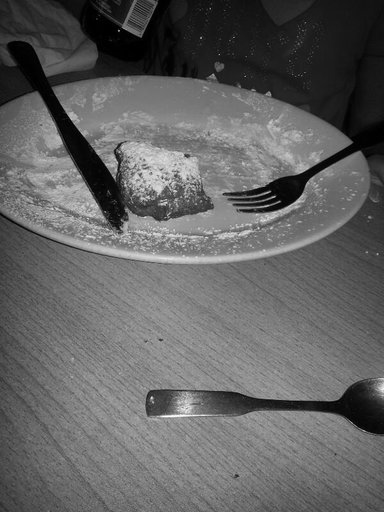

In [370]:
img.convert("L")

`#`

`-` `image_processor` 살펴보기 

In [367]:
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [368]:
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

`-` 코드는 아래와 같이 단순화하여 이해할 수 있음. 

In [362]:
_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop((224,224)), 
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food_transformed = food.with_transform(transforms)

## E. 모델생성 

`-` 아래의 코드를 관찰하자. 

In [373]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

- 그냥 별거아님.. 

`-` 아래와같이 해도 별로 상관없음

In [379]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [381]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [398]:
#model(표준화하기(자르고크기조정하기(텐서화하기(img))).reshape(1,3,224,224))

## F. 데이터콜렉터 

`-` 데이터 콜렉터 생성 

In [399]:
data_collator = transformers.DefaultDataCollator()

`-` 데이터콜렉터에게 이번에 크게 기대하는건 없음.. 그냥 배치화정도만 해주면 됨

In [423]:
food_transformed['train'][:2]['pixel_values']
# [ (3,224,224)-텐서, (3,224,224)-텐서 ] 의 형태

[tensor([[[ 0.9216,  0.9059,  0.8902,  ..., -0.1373, -0.1451, -0.1216],
          [ 0.9216,  0.9137,  0.8980,  ...,  0.3412,  0.3490,  0.3882],
          [ 0.8980,  0.9059,  0.9373,  ...,  0.6863,  0.7098,  0.7412],
          ...,
          [ 0.9529,  0.9529,  0.9451,  ...,  0.8039,  0.7961,  0.7961],
          [ 0.9608,  0.9529,  0.9608,  ...,  0.8039,  0.8039,  0.7961],
          [ 0.9686,  0.9608,  0.9608,  ...,  0.8039,  0.7961,  0.7882]],
 
         [[ 0.7725,  0.7490,  0.7333,  ..., -0.2392, -0.2549, -0.1922],
          [ 0.7647,  0.7412,  0.7333,  ...,  0.2392,  0.2471,  0.3176],
          [ 0.6314,  0.6471,  0.7176,  ...,  0.6078,  0.6392,  0.6784],
          ...,
          [ 0.9451,  0.9451,  0.9373,  ...,  0.6863,  0.6784,  0.6941],
          [ 0.9529,  0.9451,  0.9373,  ...,  0.6863,  0.6863,  0.6941],
          [ 0.9608,  0.9451,  0.9294,  ...,  0.6863,  0.6784,  0.6863]],
 
         [[ 0.7804,  0.7961,  0.8118,  ..., -0.2549, -0.2549, -0.1922],
          [ 0.6627,  0.7098,

In [428]:
data_collator([food_transformed['train'][0],food_transformed['train'][1]])['pixel_values'].shape
# (2,3,224,224)-텐서

torch.Size([2, 3, 224, 224])

## G. 추론 

`-` 코드정리1에 의하여 이미 학습되어있는 Trainer 

In [451]:
classifier = transformers.pipeline("image-classification", model="my_awesome_food_model/checkpoint-186")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


`-` image url 에서 PIL 오브젝트 만들기: GPT 답변 

```Python
from PIL import Image
import requests
from io import BytesIO

# 이미지 URL
url = "https://example.com/image.jpg"

# URL에서 이미지 불러오기
response = requests.get(url)
image = Image.open(BytesIO(response.content))

# 이미지 확인
image.show()
```

In [452]:
from PIL import Image
import requests
from io import BytesIO
# 이미지 URL
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Shoyu_ramen%2C_at_Kasukabe_Station_%282014.05.05%29_1.jpg/500px-Shoyu_ramen%2C_at_Kasukabe_Station_%282014.05.05%29_1.jpg"

# URL에서 이미지 불러오기
response = requests.get(url)
image = Image.open(BytesIO(response.content))

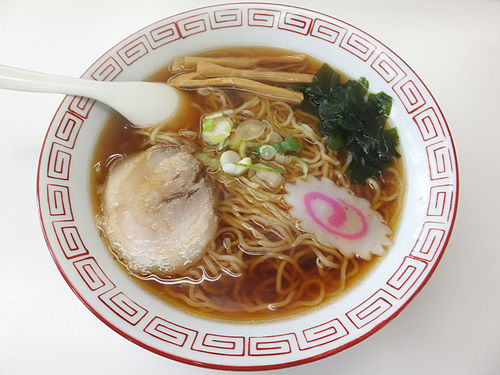

In [453]:
image

In [454]:
classifier(image)

[{'label': 'ramen', 'score': 0.9723917841911316},
 {'label': 'prime_rib', 'score': 0.6323286890983582},
 {'label': 'chicken_wings', 'score': 0.5933451652526855},
 {'label': 'pork_chop', 'score': 0.5822263956069946},
 {'label': 'beignets', 'score': 0.5541594624519348}]

# 6. 코드정리2

In [382]:
## Step1 
food = datasets.load_dataset("food101", split="train[:5000]").train_test_split(test_size=0.2)
def transforms(examples):
    _transforms = torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224), 
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    examples["pixel_values"] = [_transforms(img) for img in examples["image"]]
    del examples["image"]
    return examples
food = food.with_transform(transforms)
## Step2 
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)
## Step3 
data_collator = transformers.DefaultDataCollator()
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)
training_args = transformers.TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)
trainer.train()
## Step4 

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
0,2.668400,2.506724,0.829000
2,1.576300,1.610220,0.889000


TrainOutput(global_step=186, training_loss=2.4196897424677366, metrics={'train_runtime': 141.9247, 'train_samples_per_second': 84.552, 'train_steps_per_second': 1.311, 'total_flos': 9.232831524962304e+17, 'train_loss': 2.4196897424677366, 'epoch': 2.976})

In [386]:
# Step4 
ds = datasets.load_dataset("food101", split="validation[:10]")
image = ds["image"][0]
classifier = transformers.pipeline("image-classification", model="my_awesome_food_model/checkpoint-186")
classifier(image)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'beignets', 'score': 0.964948832988739},
 {'label': 'bruschetta', 'score': 0.6403759717941284},
 {'label': 'chicken_wings', 'score': 0.606441080570221},
 {'label': 'prime_rib', 'score': 0.5967445969581604},
 {'label': 'ramen', 'score': 0.5884137153625488}]